In [159]:
pip install keras-tuner

In [160]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
from kerastuner.tuners import RandomSearch
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Read the CSV file into a DataFrame
df = pd.read_csv('/content/Final_Dataset_2013_2022.csv')

# Display the first 5 rows
print(df.head())

# Print the column names and their data types
print(df.info())

   index  AADT_VN  BEGIN_POIN  COUNTY_COD  END_POINT  IRI_VN  IS_IMPROVED  \
0      0    44290         5.3          97        5.4      44            0   
1      1    44750         5.3          97        5.4      48            0   
2      2    45760         5.3          97        5.4      80            1   
3      3    48670         5.3          97        5.4      43            1   
4      4    49080         5.3          97        5.4      39            1   

       ROUTE_ID  SPEED_LIMI  THROUGH_LA  YEAR_RECOR  curval  \
0  IN0000100000        60.0           4        2013     263   
1  IN0000100000        60.0           4        2014     268   
2  IN0000100000        60.0           4        2015     192   
3  IN0000100000        70.0           4        2016     176   
4  IN0000100000        70.0           4        2017     205   

                                      geometry_paths  tmiles  tons  value  
0  [[[-88.31770505199995, 30.49976574300007], [-8...      15   716    270  
1  [[[

In [161]:
df.index = range(1, len(df) + 1)
df.reset_index(inplace=True, names=['new_index'])  # Add 'new_index' as a column

# Method 2: Creating a new column directly
df['new_index'] = range(1, len(df) + 1)

# If you want 'index' instead of 'new_index'
df.rename(columns={'new_index': 'index'}, inplace=True)


In [162]:
print(df.columns)

Index(['index', 'index', 'AADT_VN', 'BEGIN_POIN', 'COUNTY_COD', 'END_POINT',
       'IRI_VN', 'IS_IMPROVED', 'ROUTE_ID', 'SPEED_LIMI', 'THROUGH_LA',
       'YEAR_RECOR', 'curval', 'geometry_paths', 'tmiles', 'tons', 'value'],
      dtype='object')


In [163]:
df['index'] = df['index'] + 1

In [164]:
train_months = df['index']

In [165]:
cols = ['AADT_VN', 'BEGIN_POIN', 'COUNTY_COD', 'END_POINT', 'IS_IMPROVED', 'SPEED_LIMI', 'THROUGH_LA', 'YEAR_RECOR', 'curval', 'tmiles', 'tons', 'value']
target_col = 'IRI_VN'

In [166]:
df_for_training = df[cols + [target_col]]

In [167]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [168]:
trainX = []
trainY = []

In [169]:
n_future = 1
n_past = 9

In [170]:
for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:len(cols)])  # Only features
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, len(cols)])

In [171]:
print(trainX[0])
print(trainY[0])

[[-0.34110114 -1.31424975  0.74796505 -1.31425057 -0.71247729  0.58182594
  -0.65901694 -1.48595576 -1.15411307 -1.1350767  -1.6503149  -1.11213563]
 [-0.32401706 -1.31424975  0.74796505 -1.31425057 -0.71247729  0.58182594
  -0.65901694 -1.12450706 -1.14879353 -1.12163819 -1.62843867 -1.09547954]
 [-0.28650636 -1.31424975  0.74796505 -1.31425057  1.40355351  0.58182594
  -0.65901694 -0.76305836 -1.22965062 -1.10819969 -1.61042296 -1.0892335 ]
 [-0.17843098 -1.31424975  0.74796505 -1.31425057  1.40355351  0.88838129
  -0.65901694 -0.40160966 -1.24667317 -1.10819969 -1.60720587 -1.06945439]
 [-0.16320387 -1.31424975  0.74796505 -1.31425057  1.40355351  0.88838129
  -0.65901694 -0.04016097 -1.2158198  -1.10819969 -1.61492689 -1.06633138]
 [-0.08684545 -1.31424975  0.74796505 -1.31425057 -0.71247729  0.88838129
  -0.65901694  0.32128773 -1.17645516 -1.10819969 -1.6014151  -1.05696232]
 [-0.10404095 -1.31424975  0.74796505 -1.31425057 -0.71247729  0.88838129
  -0.65901694  0.68273643 -0.987

In [172]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [173]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (7110, 9, 12).
trainY shape == (7110, 1).


In [174]:
print(trainY)

[[-0.32214006]
 [-0.48315354]
 [-0.08956502]
 ...
 [ 5.58168772]
 [ 1.43111789]
 [ 1.39533711]]


In [175]:
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

In [176]:
print(X_train[0])
print(y_train[0])

[[-0.99401014  0.30487642  1.21721743  0.30487625 -0.71247729 -1.25750615
  -0.65901694  0.68273643 -0.86047415  1.56606202  1.13118274 -0.86749927]
 [-1.10045139  0.30487642  1.21721743  0.30487625 -0.71247729  0.88838129
  -0.65901694  1.04418513 -1.01261316  1.49886951  1.02308845 -0.93308264]
 [-1.09150081  0.30487642  1.21721743  0.30487625 -0.71247729  0.88838129
  -0.65901694  1.76708252 -0.57960213  1.79451653  1.34737131 -0.89456542]
 [-1.19976189  0.30591632  1.21721743  0.30591615 -0.71247729 -1.25750615
  -0.65901694 -1.48595576  0.6449573  -0.24813563  0.17828012  0.63259008]
 [-1.18156363  0.30591632  1.21721743  0.30591615  1.40355351 -1.25750615
  -0.65901694 -1.12450706  0.87050604 -0.23469713  0.2651416   0.83975023]
 [-1.18416338  0.30591632  1.21721743  0.30591615 -0.71247729 -1.25750615
  -0.65901694 -0.76305836  0.96306613 -0.27501263  0.16219466  1.00839317]
 [-1.15928005  0.30591632  1.21721743  0.30591615 -0.71247729 -1.25750615
  -0.65901694 -0.40160966  0.994

In [177]:
print('X_train shape == {}.'.format(X_train.shape))
print('X_test shape == {}.'.format(X_test.shape))
print('y_train shape == {}.'.format(y_train.shape))
print('y_test shape == {}.'.format(y_test.shape))

X_train shape == (5688, 9, 12).
X_test shape == (1422, 9, 12).
y_train shape == (5688, 1).
y_test shape == (1422, 1).


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 9, 128)         │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 9, 96)          │        24,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 9, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 9, 96)          │        27,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 9, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 9, 96)          │        27,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 9, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,785 (542.13 KB)

 Trainable params: 138,785 (542.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 1.4873 - val_loss: 1.1561
Epoch 2/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 1.1581 - val_loss: 1.0265
Epoch 3/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.0648 - val_loss: 0.9736
Epoch 4/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.9893 - val_loss: 0.9076
Epoch 5/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.9094 - val_loss: 0.8868
Epoch 6/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.8496 - val_loss: 0.8648
Epoch 7/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.8708 - val_loss: 0.7771
Epoch 8/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.7944 - val_loss: 0.7964
Epoch 9/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.7621 - val_loss: 0.7366
Epoch 10/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.7522 - val_loss: 0.7372
Epoch 11/200
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.7038 - val_loss: 0.7062
Epoch 12/200
320/320 ━━━━━━━━━━

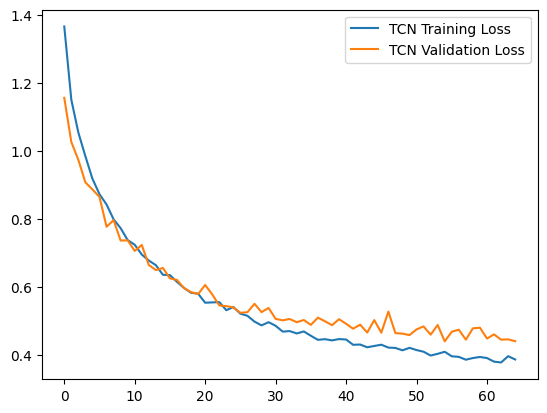

In [178]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from tensorflow.keras.regularizers import l2, l1, l1_l2

def build_tcn_model(input_shape, output_units):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Input layer

    # Temporal Convolutional Blocks
    model.add(Conv1D(filters=128, kernel_size=2, padding='causal', activation='relu', dilation_rate=1, kernel_regularizer = l1(0.0001)))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=96, kernel_size=2, padding='causal', activation='relu', dilation_rate=2, kernel_regularizer = l1(0.0001)))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=96, kernel_size=3, padding='causal', activation='relu', dilation_rate=4, kernel_regularizer = l1(0.0001)))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=96, kernel_size=3, padding='causal', activation='relu', dilation_rate=4, kernel_regularizer = l1(0.0001)))
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=l1(0.0001)))
    model.add(Dropout(0.1))
    model.add(Dense(output_units))  # Output layer

    model.compile(optimizer=Adam(learning_rate=0.00030508), loss='mse')
    return model

# --- Usage in your code ---
input_shape = (X_train.shape[1], X_train.shape[2])  # (n_past, num_features)
output_units = trainY.shape[1]  # 1 (for your target variable)

tcn_model = build_tcn_model(input_shape, output_units)
tcn_model.summary()

# --- Callbacks for training ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- Train the TCN ---
tcn_history = tcn_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stopping]
)

# --- Visualization ---  (Adapt as needed)
plt.plot(tcn_history.history['loss'], label='TCN Training Loss')
plt.plot(tcn_history.history['val_loss'], label='TCN Validation Loss')
plt.legend()
plt.show()

In [179]:
# --- Evaluate ---
y_pred_tcn = tcn_model.predict(X_test)
mse_tcn = mean_squared_error(y_test, y_pred_tcn)  # Assuming y_test is still available
print(f"TCN Mean Squared Error: {mse_tcn}")

# --- R2 Score ---
y_train_pred_tcn = tcn_model.predict(X_train)
r2_train_tcn = r2_score(y_train, y_train_pred_tcn)
r2_test_tcn = r2_score(y_test, y_pred_tcn)

print(f'TCN Training R²: {r2_train_tcn}')
print(f'TCN Test R²: {r2_test_tcn}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
TCN Mean Squared Error: 0.302997925245911
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
TCN Training R²: 0.8129033437113325
TCN Test R²: 0.7115069723104698


In [180]:
y_pred_original = np.zeros((y_pred_tcn.shape[0], df_for_training.shape[1]))
y_pred_original[:, -1] = y_pred_tcn[:, 0]
y_pred_original = scaler.inverse_transform(y_pred_original)[:, -1]

In [181]:
# Create a dummy array for y_test as well
y_test_original = np.zeros((y_test.shape[0], df_for_training.shape[1]))
y_test_original[:, -1] = y_test[:, 0]
y_test_original = scaler.inverse_transform(y_test_original)[:, -1]

In [182]:
print(y_pred_original)
print(y_test_original)

[ 75.99950521  40.8264503  123.37486443 ...  51.53018666 162.47322588
  44.54450024]
[93. 33. 48. ... 68. 63. 45.]


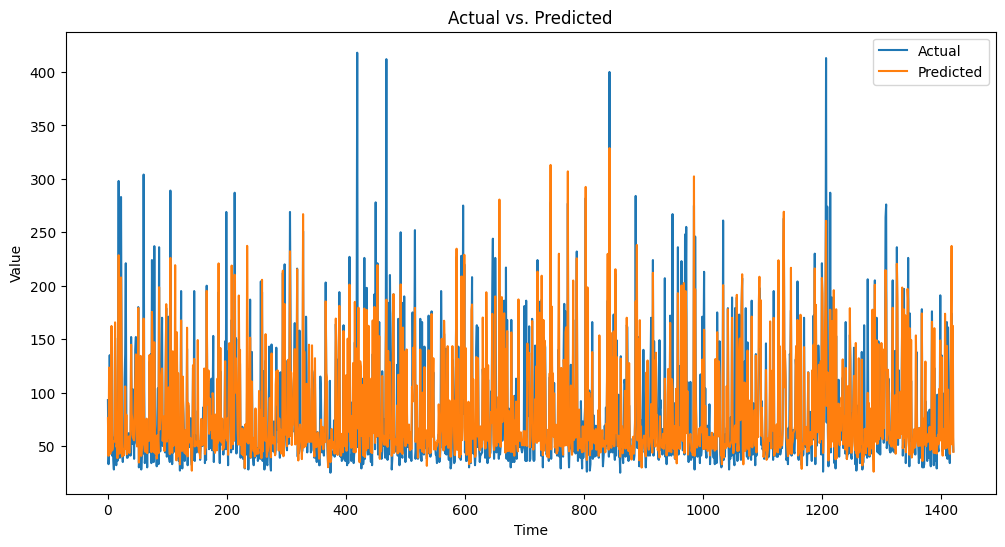

In [183]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual')
plt.plot(y_pred_original, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()